In [1]:
### summary: TOP SCORES: 
#52.5% with gaussian naive bayes
#52.5% with k-nn with ~200 neighbors
#52.5% with logistic regression and C~1e-2
#52% with a 2 depth decision tree
#always going for 1 -> 51%

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn import linear_model
matplotlib.style.use('ggplot')
%matplotlib inline


In [2]:
numerai_data = pd.read_csv("../numerai_datasets/numerai_training_data.csv")
print numerai_data.head(10)

#separating train and test
frac_for_training = 0.80
training_data = numerai_data.sample(frac=frac_for_training)
validation_data = numerai_data.drop(training_data.index)
check = pd.merge(training_data, validation_data, how='inner')

training_data.drop('validation', axis=1, inplace=True)
validation_data.drop('validation', axis=1, inplace=True)

print('\n\n\nSize of datasets: total - %s, train - %s, test - %s, intersect: %s' %(
        numerai_data.shape[0], training_data.shape[0], validation_data.shape[0], check.shape[0]))

          f1         f2         f3         f4         f5         f6  \
0  134182390   97300587  135824563   90767607   87687197   65148427   
1   76630357  132348601   78121737  102794263  120848626  128752983   
2  111610401  132186734   83887688  120772423  133722193  100560251   
3   72896251  113365043   72912608  126007508  127949612   74975809   
4  113253706   96665624   89391907   77862818   91855586  100094204   
5  122837395   71633727  125829672   73401946   66388998   71572170   
6  116917069   97255589  109352915   77622874   76834712   84847106   
7  108136714  110264481   99080283   95949194  108265520  100203479   
8  116917069  127552518  124961581  102269449  107669715   84416921   
9  107480622   91552319   78127446   84411308   98566229   84213901   

          f7         f8         f9        f10        f11        f12  \
0  109834029  131613166  135533479   92106582   98111205   87052852   
1   71827456   95945691   98115812  135285479  137364637  130062214   
2   6

In [3]:
#binarizing c1:

categories = list(set(list(training_data['c1'])))

for cat in categories:
    training_data[cat] = training_data['c1']==cat

features = list(set(training_data.columns).difference({'target', 'validation','c1'}))

In [4]:
print features

['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'c1_20', 'c1_21', 'c1_22', 'c1_23', 'c1_24', 'f12', 'f13', 'c1_19', 'c1_18', 'c1_11', 'c1_10', 'c1_13', 'c1_12', 'c1_15', 'c1_14', 'c1_17', 'c1_16', 'c1_1', 'c1_3', 'c1_5', 'c1_4', 'c1_7', 'c1_6', 'c1_9', 'c1_8', 'f10', 'f11', 'f14']


['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'c1_20', 'c1_21', 'c1_22', 'c1_23', 'c1_24', 'f12', 'f13', 'c1_19', 'c1_18', 'c1_11', 'c1_10', 'c1_13', 'c1_12', 'c1_15', 'c1_14', 'c1_17', 'c1_16', 'c1_1', 'c1_3', 'c1_5', 'c1_4', 'c1_7', 'c1_6', 'c1_9', 'c1_8', 'f10', 'f11', 'f14']


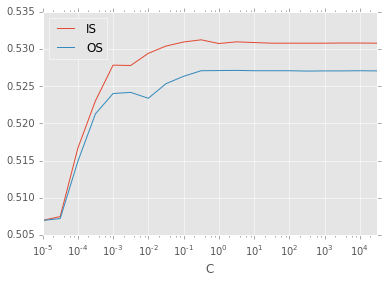

In [15]:
#Logistic regression

from sklearn.naive_bayes import GaussianNB
from sklearn.cross_validation import cross_val_score
from sklearn import preprocessing
import math

params = np.exp(np.arange(-5.0, 5.0,.5)*math.log(10))
#features = features[0:(1+np.argmax(np.cumsum(np.array(pca_.explained_variance_ratio_))>variance_cutoff))]#REDUCE FEATURES
print features

logistic_reg_training_data = training_data.copy()
#features = [f for f in set(logistic_reg_training_data.columns) if f.startswith("f")]
minmax_scale = preprocessing.MinMaxScaler().fit(logistic_reg_training_data[features])
logistic_reg_training_data[features] = minmax_scale.transform(logistic_reg_training_data[features])

def apply_param(p):
    lreg_model = sklearn.linear_model.LogisticRegression(C=p)
    lreg_model.fit(logistic_reg_training_data[features], logistic_reg_training_data["target"])
    IS = lreg_model.score(logistic_reg_training_data[features], logistic_reg_training_data["target"])
    OS = np.mean(cross_val_score(lreg_model, logistic_reg_training_data[features], logistic_reg_training_data["target"], cv=10))
    return pd.DataFrame([np.array([p, IS, OS])], columns=['C', 'IS', 'OS']) 

scores = pd.concat(map(apply_param, params))
scores.plot(x='C',logx=True)





In [12]:
from sklearn.naive_bayes import GaussianNB
from sklearn.cross_validation import cross_val_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

in_sample_scores_per_category = dict()
variance_cutoff = 0.90

basis_quant_features = [f for f in set(training_data.columns) if f.startswith("f")]
categories = list(set(list(training_data['c1'])))

def classify(cat):
    training_data_scaled = training_data[training_data['c1']==cat].copy(deep=True)
    quant_features = []
    
    for f in basis_quant_features:
        if (len(list(set(list(training_data[[f]]))))>1):
            quant_features = quant_features + [f]
    
    if (len(quant_features)==0):
        highest_target = 1 if sum(map(int,list(training_data_scaled['target']==1)))*2>training_data_scaled.shape[0] else 0
        preds = [highest_target]*training_data_scaled.shape[0]
        actuals = list(training_data_scaled["target"])
        return (len([pred for (pred, actual) in zip(preds, actuals) if pred==actual]),len(actuals))
    
    training_data_scaled[quant_features] = scale(training_data_scaled[quant_features], axis=0, with_mean=True, with_std=True, copy=True)
    #ca_ = PCA()
    #ca_.fit(training_data_scaled[quant_features])
    training_data_pcaed = training_data_scaled.copy(deep=True)
    #training_data_pcaed[quant_features] = pca_.transform(training_data_scaled[quant_features])
    features = quant_features#[0:(1+np.argmax(np.cumsum(np.array(pca_.explained_variance_ratio_))>variance_cutoff))]#REDUCE FEATURES
    clf = GaussianNB()
    clf.fit(training_data_pcaed[features], training_data_pcaed["target"])
    preds = clf.predict(training_data_pcaed[features], training_data_pcaed["target"])
    actuals = list(training_data_pcaed["target"])
    return (len([pred for (pred, actual) in zip(preds, actuals) if pred==actual]),len(actuals))

couples = map(classify, categories)
score = sum([acc for (acc, wrong) in couples])/float(sum([wrong for (acc, wrong) in couples]))
print score


0.517624347036


In [5]:
training_data.head(10)
    

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,c1,target
4638,111706861,97524668,100942558,83427635,88611659,128978979,109996625,113772377,99126300,125333925,110368997,84495298,121133085,120923143,c1_15,0
54346,87097384,76152872,131480217,120541721,115601609,106927787,117171649,76311684,127823942,85983471,99821164,82904416,110366500,126933296,c1_8,0
31441,91815938,132125202,90180833,121530796,127032370,132723848,116930026,75300104,80740446,134761305,126091480,131021720,126161394,97550898,c1_16,0
49174,77202752,122881414,93857717,115613575,116785152,84771601,89148841,82474870,104341302,126905268,124835040,119004122,84017268,85734274,c1_15,1
39929,127022191,82462298,94200679,95846281,81297421,67362736,115891543,119642836,102866734,71591637,93693938,83410876,64499996,131881834,c1_20,0
38046,111936022,127926282,83886096,101326921,98288665,128191095,94700182,113249066,81133688,110100806,104343854,123046799,126489282,86473009,c1_5,1
36609,129041774,81790922,109352915,91819159,72221729,93979482,98505969,124282338,117457342,80144716,92857890,87314442,108596322,116271528,c1_10,1
19118,67903419,83231083,88737304,126420783,115736636,83297252,64493688,63728389,96608846,108676491,112070525,71582674,90316707,71350845,c1_10,1
49141,91760483,92348989,82838859,72089929,76075785,128464586,106168642,89916280,80613601,98304716,99821164,87052852,131170208,107309715,c1_15,0
23648,111936022,91751182,114090148,70918761,77471548,84609793,70288263,93847599,99020519,77071290,87713797,76546156,85066646,97324209,c1_18,1


In [7]:
cat = 'c1_8'
training_data_scaled = training_data[training_data['c1']==cat]
print training_data_scaled.head(5)
    


             f1         f2         f3         f4         f5         f6  \
54346  87097384   76152872  131480217  120541721  115601609  106927787   
39665  77596276   70385664   68419205  114001857  108336059   91230839   
54074  81534662   70458915   83886097   97126503  106781973   67123497   
8928   96823999  119410420   89541049  107481006  110887127  128003041   
35618  95944958   85784337  114820132   64487433   67372544   83369529   

              f7         f8         f9        f10        f11        f12  \
54346  117171649   76311684  127823942   85983471   99821164   82904416   
39665  112263611   71595346   69738050   72164700   68445906   71453921   
54074   99486844   89132840   91781173  114387991  118059127   84018268   
8928    71687119  105513307   99020519  119507876  129630258  112787577   
35618  127533369  101228818  115147768   67469630   69522293   72486237   

             f13        f14    c1  target  
54346  110366500  126933296  c1_8       0  
39665   78568461

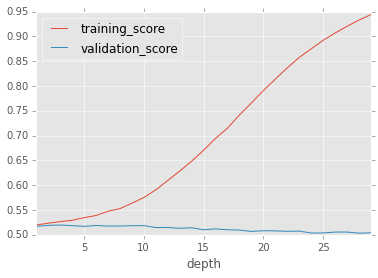

In [5]:
#classification score with a single regression tree conditional on category

from sklearn import tree
from sklearn.cross_validation import cross_val_score

#features = features[0:(1+np.argmax(np.cumsum(np.array(pca_.explained_variance_ratio_))>variance_cutoff))]#REDUCE FEATURES
#print features

max_depths = range(1,30)
def cv_score(depth, printTree=False):
    clf = tree.DecisionTreeClassifier(max_depth=depth)
    clf.fit(training_data[features], training_data["target"])
    s = clf.score(training_data[features], training_data["target"])
    m = np.mean(cross_val_score(clf, training_data[features], training_data["target"], cv=5))
    dat = np.array([depth, s, m])
    if printTree:
        with open('./ClassificationTrees/singleClassifTreeWithDepth'+str(depth)+'.dot', 'w') as my_file:
            my_file = tree.export_graphviz(clf, out_file = my_file)
    return pd.DataFrame([dat],columns=['depth','training_score', 'validation_score'])

single_classif_tree_scores = pd.concat(map(lambda d: cv_score(d, True), max_depths))
single_classif_tree_scores.index = single_classif_tree_scores['depth']
single_classif_tree_scores.drop('depth',axis=1, inplace=True)

single_classif_tree_scores.plot(legend=True, grid=True)
print single_classif_tree_scores

In [6]:
print single_classif_tree_scores

       training_score  validation_score
depth                                  
1            0.519782          0.517102
2            0.523348          0.519010
3            0.526505          0.519669
4            0.529230          0.518442
5            0.534454          0.517057
6            0.538951          0.518783
7            0.547445          0.517579
8            0.552737          0.517647
9            0.563684          0.518283
10           0.575085          0.518510
11           0.590506          0.514649
12           0.609425          0.514740
13           0.628503          0.513128
14           0.648353          0.514150
15           0.670452          0.510266
16           0.694458          0.511924
17           0.715058          0.510175
18           0.741722          0.509608
19           0.765910          0.506814
20           0.790824          0.508245
21           0.814036          0.507881
22           0.836634          0.507041
23           0.857665          0.507472


In [ ]:
#LDA / QDA







